In [33]:
import commonFunctions as cf
from BacktestPlatform import TradeBlotter, Details
import numpy as np
import pandas as pd
import scipy as sp
from datetime import datetime, date, timedelta
from scipy import stats
import time
import matplotlib.pyplot as plt
import TrendFollowingPlatform as tfp
from statsmodels.tsa import stattools
%matplotlib inline

# turn off the warning in backtesting
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
url_cryto = "https://finance.yahoo.com/cryptocurrencies"
symbols = cf.get_symbols_multiple_pages(url_cryto, attr="data-symbol")
cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
print(len(symbols))

Get Symbol Finished
111


In [3]:
end = datetime.now()
start = end - timedelta(days=365)
data = cf.get_data(symbols, start=start, end=end)

[*********************100%***********************]  111 of 111 downloaded


In [6]:
data_dict = cf.get_data_dict(symbols, data, cols, batch=10)

Finished


In [7]:
data_dict['ADA-USD'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-09,0.1392,0.1392,0.1463,0.1392,0.1451,554619.0
2018-07-10,0.1280,0.1280,0.1406,0.1268,0.1392,1604756.0
2018-07-11,0.1308,0.1308,0.1340,0.1249,0.1280,657459.0
2018-07-12,0.1258,0.1258,0.1310,0.1241,0.1308,161469.0
2018-07-13,0.1258,0.1258,0.1258,0.1258,0.1258,0.0


In [8]:
df_sys = pd.read_excel("inputs/Systems.xlsx")
df_sys

,systemID,systemType,nlookback,entrylookback,exitlookback
0,s1,pricebreakout,20,20,10
1,s2,pricebreakout,20,55,20


In [55]:
total_capital = 10000
sys_list = tfp.get_system_dict_list(df_sys)
df_stats = calc_stats(data_dict['LTC-USD'], total_capital, sys_list)
df_stats.head()

,Open,High,Low,Close,Adj Close,Volume,TR,N,Unit Size,s1_entry_20_H,s1_entry_20_L,s1_exit_10_H,s1_exit_10_L,s2_entry_55_H,s2_entry_55_L,s2_exit_20_H,s2_exit_20_L
Date,,,,,,,,,,,,,,,,,
2018-09-01,66.47,66.47,67.88,62.11,62.12,25828917.0,6.25,0.798277,0.0,66.47,56.49,67.88,57.08,89.16,56.49,67.88,53.4
2018-09-02,66.22,66.22,66.99,64.20,66.47,14702952.0,4.10,0.963364,0.0,66.47,56.49,67.88,57.08,89.16,56.49,67.88,53.4
2018-09-03,65.38,65.38,66.50,64.41,66.23,12060075.0,-1.09,0.860695,0.0,66.47,56.78,67.88,57.08,89.16,56.49,67.88,53.4
2018-09-04,67.68,67.68,69.38,65.35,65.38,23820410.0,1.45,0.890161,0.0,67.68,56.78,69.38,57.08,89.16,56.49,69.38,53.4
2018-09-05,57.73,57.73,68.33,57.52,67.68,44300364.0,-2.98,0.696653,0.0,67.68,56.78,69.38,57.73,89.16,56.49,69.38,53.4


In [56]:
def calc_stats(df, total_capital, sys_list):
    """
    Append stats columns to market data frame.
    
    Params:
    mkt_data -- input market data frame to modify
    mkt_id -- market ID
    total_capital -- equity/account
    df_spec -- dataframe containing market specification
    sys_list -- a list of dictionaries containing system info
    
    """
    mkt_data = df.copy()
    #mkt_data = mkt_data.loc[mkt_data['Indicator'] == 'False']
    mkt_data['TR'] = np.maximum(np.maximum(mkt_data['High']-mkt_data['Low'],\
                     mkt_data['High']-mkt_data['Adj Close'].shift()),\
                     mkt_data['Close'].shift()-mkt_data['Low'])

    N_list = [np.nan]*len(mkt_data['TR'])
    n = sys_list[0]['nlookback']
    N_list[n] = mkt_data['TR'][1:(n+1)].mean()

    for i in range(n+1, len(N_list)):
        N_list[i] = (1-1/n)*N_list[i-1] + 1/n*mkt_data['TR'][i]

    mkt_data['N'] = N_list

    #DPP = df_spec['FUT VAL PT'][mkt_id[:3]]
    DPP = 1/1e-8 * 0.01
    mkt_data['Unit Size']  = np.floor(0.01 * total_capital / (mkt_data['N'] * DPP))

    for sys in sys_list:
        # compute high/low over entry/exit lookback period
        name1 = sys['systemID'] + '_' + 'entry_' + str(sys['entrylookback'])
        mkt_data[str(name1+'_H')] = mkt_data['High'].rolling(window=sys['entrylookback']).max()
        mkt_data[str(name1+'_L')] = mkt_data['Low'].rolling(window=sys['entrylookback']).min()
        name2 = sys['systemID'] + '_' + 'exit_' + str(sys['exitlookback'])
        mkt_data[str(name2+'_H')] = mkt_data['Low'].rolling(window=sys['exitlookback']).max()
        mkt_data[str(name2+'_L')] = mkt_data['High'].rolling(window=sys['exitlookback']).min()
        
    mkt_data = mkt_data.dropna()
    return mkt_data

In [57]:
markets = {'LTC-USD': df_stats}


In [65]:
start_date = datetime(2018, 9, 1)
end_date = datetime(2019, 7, 9)
total_capital = 10000
# Specify the information, i.e. columns in the history
port_col_list = ['Units', 'Contracts', 'Stop Level', 'Unrealized PnL', 'Realized PnL', 'LongOrNot']
# sys_index = System 1, sys_index2 = System 2
sys_index, sys_index2 = [8, 9, 10, 11], [12, 13, 14, 15]
# Specify the information, i.e. columns in the blotter
col_list = ['MktID', 'Entry Date', 'LongOrNot', 'Live', 'Entry Price', 'N', 
            'Unit Size', 'Units', 'Stop Level', 'Exit Price', 'Exit Date', 
            'StopOrExit', 'Realized PnL', 'Nth Unit']
# Limits for single market, direction, closely and loosely correlated markets
switch = [False, False, False, False]
#limits = [4, 12, 6, 10]

# Recent data stop_level_factor = 1
#=======================
stop_level_factor = 1 #=
#=======================

t = time.time()

print("Backtest Started...")
blotter1, history   = Backtest(markets, total_capital, col_list, start_date, 
                               end_date, port_col_list, sys_index, whipsaw_stop_level, 
                               switch, 
                               #limits, corr_mkts, 
                               stop_level_factor)
print("Backtest Finished.")
print("Time used = ", time.time() - t, "seconds.")

Backtest Started...
0
50
100
150
200
Backtest Finished.
Time used =  1.6146807670593262 seconds.


In [66]:
blotter1

,MktID,Entry Date,Direction,Live,Entry Price,N,Unit Size,Units,Stop Level,Exit Price,Exit Date,StopOrExit,Realized PnL,Nth Unit
0,LTC-USD,2018-09-03,Long,False,65.38,-1.09,0,1,65.925,69.380,2018-09-04,Exit,0.000,1
1,LTC-USD,2018-09-05,Long,False,57.73,-2.98,0,1,59.220,59.220,2018-09-06,Stop,0.000,1
2,LTC-USD,2018-09-07,Long,False,55.55,-2.18,0,1,56.640,56.640,2018-09-10,Stop,0.000,1
3,LTC-USD,2018-09-11,Long,False,52.00,-1.65,0,1,52.825,52.825,2018-09-12,Stop,0.000,1
4,LTC-USD,2018-09-13,Long,False,54.55,2.55,0,1,53.275,68.330,2018-09-14,Exit,0.000,1
5,LTC-USD,2018-09-17,Long,False,52.09,-3.27,0,1,53.725,58.910,2018-09-18,Exit,0.000,1
6,LTC-USD,2018-09-19,Long,False,54.31,2.22,0,1,53.200,58.910,2018-09-20,Exit,0.000,1
7,LTC-USD,2018-09-21,Long,False,60.87,6.56,0,1,57.590,63.590,2018-09-24,Exit,0.000,1
8,LTC-USD,2018-09-25,Long,False,57.54,-0.51,0,1,57.795,63.590,2018-09-26,Exit,0.000,1
9,LTC-USD,2018-09-27,Long,False,63.22,5.68,0,1,60.380,65.610,2018-09-28,Exit,0.000,1


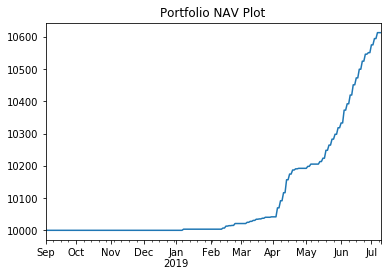

In [67]:
_,port_nav = get_portfolio_nav(history, total_capital)
temp_index = [pd.Timestamp(cur) for cur in port_nav.index]
port_nav_copy = port_nav.copy()
port_nav_copy.index = temp_index
#print("Portfolio NAV Plot")
port_nav_copy.plot(title="Portfolio NAV Plot")

In [37]:
history['LTC-USD']

,Units,Contracts,Stop Level,Unrealized PnL,Realized PnL,LongOrNot
2018-09-03,1,0,65.925,0,0,True
2018-09-04,0,0,NaN,0,0,NaN
2018-09-05,1,0,59.22,0,0,True
2018-09-06,0,0,NaN,0,0,NaN
2018-09-07,1,0,56.64,0,0,True
2018-09-10,0,0,NaN,0,0,NaN
2018-09-11,1,0,52.825,0,0,True
2018-09-12,0,0,NaN,0,0,NaN
2018-09-13,1,0,53.275,0,0,True
2018-09-14,0,0,NaN,0,0,NaN


In [61]:
def Backtest(markets, #df_spec, 
             total_capital, col_list, 
             start_date, end_date, 
             port_col_list, sys_index, get_stop_level,
             limit_switch, limits=[float('Inf'), float('Inf'), float('Inf'), float('Inf')], \
             corr_mkts=None, factor=0.5):
    """
    Return a complete blotter and portfolio history
    Params:
    markets -- dictionary of data frame
    df_spec -- market specification data frame
    limit_switch -- a list of booleans indicating whether to set limit on: 
                    single market, single direction, closely correlated markets, and loosely correlated markets
    limits -- a list of limits, default = list of infinity
    corr_mkts -- optional, correlated markets data frame
    total_capital -- total capital allocated
    col_list -- column required in trade blotter
    start_date -- start date of back-test
    end_date -- end date of back-test
    port_col_list -- column required in portfolio history
    sys_index -- columns indices related to system in market data
    get_stol_level -- a function to calculate the stop level
    limit_switch -- list of booleans 
    corr_mkts -- dataframe of correlated markets
    factor -- float control size of stop level changes for adding units. 0.5 for 1980's data, 1 for recent data
    """
    # Initialize Blotter
    blotter = pd.DataFrame(columns=col_list)
    mkt_keys = list(markets.keys())
    # Initalize history dictionary 
    history = get_initial_portfolio(mkt_keys, port_col_list)
    # Generate all dates within backtest period
    date_list = pd.bdate_range(start_date, end_date).strftime('%Y-%m-%d')
    long_units, short_units, adjust_factor, navs_ratio = 0, 0, 1, 1
    
    if limit_switch[2]:
        # Get closely correlated markets
        corr_close = corr_mkts.loc[corr_mkts.iloc[:,0] == 'Closely correlated']
        # Store data into dictionaries (key = tuple of markets, value = 0)
        close_dict, close_list = get_corr_dict(corr_close)
    else:
        close_list = []
    
    if limit_switch[3]:
        # Get loosely correlated markets
        corr_loose = corr_mkts.loc[corr_mkts.iloc[:,0] == 'Loosely correlated']
        # Store data into dictionaries (key = tuple of markets, value = 0)
        loose_dict, loose_list = get_corr_dict(corr_loose)
    else:
        loose_list = []
    
    # Loop through all dates within backtest period
    for i in range(len(date_list)):
        if i % 50 == 0:
            print(i)
         # ============================================================
        # Adjusting Factor capped at 1
        if history[mkt_keys[0]].shape[0] > 0:
            agg_hist, cur_navs = get_portfolio_nav(history, total_capital)
            navs_ratio = cur_navs.iloc[-1] / total_capital
            adjust_factor = navs_ratio if  navs_ratio < 1 else 1
          # ============================================================
          
        # Loop through all markets
        for mkt in mkt_keys:
            
            cur_port = history[mkt]     # add an empty current record to history
            #DPP = df_spec["FUT VAL PT"][mkt]
            #DPP = 1/1e-8 * 0.01
            DPP = 1
            if i == 0:
                # if it is the first trading day, initialize one record for history of that market
                history[mkt] = cur_port.append(dict(zip(cur_port.columns, \
                                              [0]*cur_port.shape[1])), ignore_index=True)
                # if it is not the first trading day,
                # copy the previous history record of that market
            else:   
                history[mkt] = cur_port.append(cur_port.iloc[i-1, ], ignore_index=True)
                history[mkt]['Realized PnL'][i] = 0
                history[mkt]['Unrealized PnL'][i] = 0
            # Check if today is the trading day of the current market
            if date_list[i] in markets[mkt].index:  
                # Check if current market has closely/loosely correlated markets
                check_close, check_loose = (mkt[:3] in close_list), (mkt[:3] in loose_list)
                close_units, loose_units = [-float('Inf'), -float('Inf')], \
                                           [-float('Inf'), -float('Inf')]
                
                if check_close:
                    # Search closely correlated dictionary
                    close_keys = list(close_dict.keys())
                    for k in range(len(close_keys)):
                        if mkt[:3] in close_keys[k]: 
                            # close_units is a list of 2
                            close_key, close_units = close_keys[k], close_dict[close_keys[k]] 
                
                if check_loose:
                    # Search loosely correlated dictionary
                    loose_keys = list(loose_dict.keys())
                    for k in range(len(loose_keys)):
                        if mkt[:3] in loose_keys[k]:
                            loose_key, loose_units = loose_keys[k], loose_dict[loose_keys[k]]    
                
                # cur_dat is a series
                cur_dat = (markets[mkt][markets[mkt].index == date_list[i]]).iloc[0, ]  
                cur_loc = markets[mkt].index.get_loc(date_list[i])
                # get previous market data record 
                prev_dat = markets[mkt].iloc[cur_loc-1,:]
                unreal_direction = 1 if history[mkt]["LongOrNot"][i] else -1
                # if changed history initialization, we need to use i-1 th contracts, i.e. last day's contracts 
                # Calculate Unrealized PnL First. If changes are made, we need to 
                # update Unrealized PnL Later
                temp_cur_unreal_pnl = (cur_dat[0] - prev_dat[0])   * \
                                      history[mkt]["Contracts"][i] * \
                                      DPP * unreal_direction
                # update unrealized pnl
                history[mkt]["Unrealized PnL"][i] = temp_cur_unreal_pnl 
                
                # Get all existing trades
                exist_trades = blotter[(blotter['MktID'] == mkt) & (blotter['Live'] == True)]
                
                # If there are existing trades, loop through all of them
                if exist_trades.shape[0] > 0:                    
                    # NOTE: for existing trades, all calculations are based on the first trade                    
                    first_trade = exist_trades.iloc[0, ]    
                    add_units = AddUnits(first_trade, cur_dat)
                    port_r_pnl, port_ur_pnl, temp_new_r_pnl = 0, 0, 0     

                    # Loop through all existing trades
                    for j in range(exist_trades.shape[0]):
                        cur_ix = exist_trades.index[j] # index of current existing trade
                        # Call Stop and Exit functions
                        stop = Stop(exist_trades.iloc[j, ], cur_dat)
                        exit = Exit(exist_trades.iloc[j, ], cur_dat, sys_index)
                        # Get entry price, num of contracts and direction of current trade
                        entry_p, n_contracts, long = blotter["Entry Price"][cur_ix], \
                                                     blotter["Unit Size"][cur_ix] * blotter["Units"][cur_ix],\
                                                     True if blotter["LongOrNot"][cur_ix] else False
                        
                        #  close the trade if stop or exit, Live = False, Save the exit date
                        if stop[0] or exit[0]: 
                            blotter["Live"][cur_ix] = False
                            blotter["Exit Date"][cur_ix] = date_list[i]
                        
                        if stop[0]: # Check Stop
                            blotter["Exit Price"][cur_ix] = stop[1]    # exit price = price level triggering stop
                            blotter['StopOrExit'][cur_ix] = 'Stop'
                            # Calculate Realinzed PnL
                            temp_rpnl = (stop[1] - entry_p) * DPP * n_contracts * (2 * long - 1)
                            blotter["Realized PnL"][cur_ix] = temp_rpnl
                            # Cumsum Realized PnL for ALL trades closed today
                            port_r_pnl += blotter["Realized PnL"][cur_ix]
                            # Cumsum TODAY's Realized PnL for ALL trades closed today 
                            temp_new_r_pnl += (stop[1] - prev_dat[0]) * DPP * n_contracts * (2 * long - 1)
                            
                            # Update long/short units
                            if blotter["LongOrNot"][cur_ix]:
                                long_units -= 1
                                if check_close: close_dict[close_key][0] -= 1
                                if check_loose: loose_dict[loose_key][0] -= 1
                                    
                            else:
                                short_units -= 1
                                if check_close: close_dict[close_key][1] -= 1
                                if check_loose: loose_dict[loose_key][1] -= 1         
                            # Update history 
                            history[mkt]["Realized PnL"][i] = temp_new_r_pnl
                            
                            if history[mkt]["Units"][i] > 0: 
                                history[mkt]["Units"][i] -= 1
                                history[mkt]["Contracts"][i] -= n_contracts
                                history[mkt]["Unrealized PnL"][i] -= (cur_dat[0] - prev_dat[0]) * \
                                                                     n_contracts * DPP * unreal_direction
                                       
                            if history[mkt]["Units"][i] == 0: 
                                history[mkt]["Stop Level"][i] = np.nan
                                history[mkt]["Contracts"][i] = 0
                                history[mkt]["Unrealized PnL"][i] = 0
                                history[mkt]["LongOrNot"][i] = np.nan
                        
                        elif exit[0]: # Check Exit
                            blotter["Exit Price"][cur_ix] = exit[1]    # exit price = price level triggering stop
                            blotter['StopOrExit'][cur_ix] = 'Exit' 
                            temp_rpnl = (exit[1] - entry_p) * DPP * n_contracts * (2 * long - 1)
                            blotter["Realized PnL"][cur_ix] = temp_rpnl
                            port_r_pnl += blotter["Realized PnL"][cur_ix]                            
                            temp_new_r_pnl += (exit[1] - prev_dat[0]) * DPP * n_contracts * (2 * long - 1)
                            
                            # Update long/short units
                            if blotter["LongOrNot"][cur_ix]:
                                long_units -= 1
                                if check_close: close_dict[close_key][0] -= 1
                                if check_loose: loose_dict[loose_key][0] -= 1
                                         
                            else:
                                short_units -= 1
                                if check_close: close_dict[close_key][1] -= 1
                                if check_loose: loose_dict[loose_key][1] -= 1
                            # Update history   
                            history[mkt].iloc[i, :] = [0, 0, np.nan, 0, temp_new_r_pnl, np.nan]
        
                        elif add_units > 0:
                            
                            long = True if first_trade["LongOrNot"] == 1 else False
                            cur_units = history[mkt]["Units"][i]                            
                            # If limit switches are on
                            br_mkt = limit_switch[0] and breach(cur_units + add_units, limits[0])
                            br_long = limit_switch[1] and breach(long_units + add_units, limits[1])
                            br_short = limit_switch[1] and breach(short_units + add_units, limits[1])
                        
                            # Check closely correlated markets if needed
                            if check_close:
                                br_close_long = breach(close_units[0] + add_units, limits[2])
                                br_close_short = breach(close_units[1] + add_units, limits[2])
                            else:
                                br_close_long, br_close_short = False, False

                            # Check loosely correlated markets if needed
                            if check_loose:
                                br_loose_long = breach(loose_units[0] + add_units, limits[3])
                                br_loose_short = breach(loose_units[1] + add_units, limits[3])
                            else:
                                br_loose_long, br_loose_short = False, False
                                
                            if long and (br_mkt or br_long or br_close_long or br_loose_long):
                                add_units = min(max(limits[0] - cur_units, 0),      \
                                                max(limits[1] - long_units, 0),     \
                                                max(limits[2] - close_units[0], 0), \
                                                max(limits[3] - loose_units[0], 0))
                            if (not long) and (br_mkt or br_short or br_close_short or br_loose_short):
                                
                                add_units = min(max(limits[0] - cur_units, 0),     \
                                                max(limits[1] - short_units, 0),   \
                                                max(limits[2] - close_units[1], 0),\
                                                max(limits[3] - loose_units[1], 0))
                            
                            if add_units == 0: # loaded continue looping all existing trades
                                #break
                                continue
                            
                            # if add_units != 0 after all limit checks, add units!
                            exist_trades2 = blotter[(blotter['MktID'] == mkt) & (blotter['Live'] == True)]
                            Nth = exist_trades2.shape[0]
                            
                            cur_units = history[mkt]["Units"][i] 
                            temp_add_units = add_units if get_stop_level == turtle_stop_level else Nth
                            new_stop_level1 = get_stop_level(cur_dat, long, True, temp_add_units, first_trade, factor)
                            entry_price_ori = first_trade['Entry Price']
                            N_ori = first_trade['N']
                            entry_price_new = entry_price_ori + 0.5 * N_ori * (2 * long - 1) * Nth
                            cur_contract_size = int(cur_dat[7]*adjust_factor)  
                            blot_record_val = [str(mkt), date_list[i], long, True, entry_price_new,   
                                               cur_dat[6], int(cur_dat[7]*adjust_factor), 1, new_stop_level1,
                                               np.nan, np.nan, np.nan, np.nan, Nth + 1]
                            
                            port_ur_pnl += (cur_dat[0] - entry_price_new) *\
                                            cur_contract_size * DPP * unreal_direction                    
                            new_blot_record = dict(zip(col_list, blot_record_val))
                            temp_blot_record = [new_blot_record]
                            count_nth = 0
                            
                            for a in range(2, int(add_units)+1):
                                cur_Nth = temp_blot_record[count_nth]['Nth Unit']
                                temp_add_units = add_units if get_stop_level == turtle_stop_level else cur_Nth
                                cur_stop_level = get_stop_level(cur_dat, long, True, temp_add_units, first_trade, factor=factor)
                                cur_entry_price = entry_price_ori + 0.5  * N_ori * (2 * long - 1) * cur_Nth
                                port_ur_pnl += (cur_dat[0] - cur_entry_price) * \
                                               cur_contract_size * DPP * unreal_direction

                                blot_record_val = [str(mkt), date_list[i], long, True, cur_entry_price,
                                           cur_dat[6], cur_contract_size, 1, cur_stop_level,
                                           np.nan, np.nan, np.nan, np.nan, cur_Nth + 1]
                                
                                new_blot_record = dict(zip(col_list, blot_record_val))
                                temp_blot_record.append(new_blot_record)
                                count_nth += 1
                            
                            temp_df = pd.DataFrame(temp_blot_record)
                            blotter = pd.concat([blotter, temp_df], ignore_index=True)
                            if get_stop_level == turtle_stop_level:
                                for j in range(exist_trades.shape[0]):   
                                    cur_ix = exist_trades.index[j]
                                    blotter["Stop Level"][cur_ix] = new_stop_level1
                                    
                            # Update history
                            history[mkt]["Units"][i] += add_units
                            history[mkt]["Contracts"][i] += add_units*cur_contract_size   
                            history[mkt]["LongOrNot"][i] = long
                            history[mkt]["Stop Level"][i] = new_stop_level1
                            history[mkt]["Realized PnL"][i] = 0   
                            history[mkt]["Unrealized PnL"][i] += port_ur_pnl   
                            # Update long/short units
                            if long:
                                long_units += add_units
                                if check_close: close_dict[close_key][0] += add_units
                                if check_loose: loose_dict[loose_key][0] += add_units
                            
                            else:
                                short_units += add_units
                                if check_close: close_dict[close_key][1] += add_units
                                if check_loose: loose_dict[loose_key][1] += add_units
                # If NO existing trades, check for new break outs
                else:
                    
                    cur_contract_size = int(cur_dat[7] * adjust_factor)
                    br_mkt   = limit_switch[0] and breach(history[mkt]["Units"][i], limits[0])
                    br_long  = limit_switch[1] and breach(long_units, limits[1])
                    br_short = limit_switch[1] and breach(short_units, limits[1])
                    entry_price = 0
                    # if full loaded for this market, skip to next market
                    if br_mkt:     
                        continue
                    
                    # Check closely correlated markets if needed
                    if check_close:
                        br_close_long = breach(close_units[0], limits[2])
                        br_close_short = breach(close_units[1], limits[2])
                    else:
                        br_close_long, br_close_short = False, False
                    
                    # Check loosely correlated markets if needed
                    if check_loose:
                        br_loose_long = breach(loose_units[0], limits[3])
                        br_loose_short = breach(loose_units[1], limits[3])
                    else:
                        br_loose_long, br_loose_short = False, False
                    
                    # Add Trade: Breakout High => Long (cur_dat[2] <= cur_dat[9])
                    if (not br_long) and (not br_close_long) and \
                       (not br_loose_long) and (cur_dat[1] >= cur_dat[8]):
                        # Update long_units
                        long_units += 1  
                        # Update closely correlated units
                        if check_close: close_dict[close_key][0] += 1
                        # Update loosely correlated units
                        if check_loose: loose_dict[loose_key][0] += 1
                        # Update blotter
                        entry_price = cur_dat[1]
                        stop_level = get_stop_level(cur_dat, long=True, factor=factor)   
                        record_val = [str(mkt), date_list[i], True, True, cur_dat[1],
                                     cur_dat[6], cur_contract_size, 1, stop_level,
                                     np.nan, np.nan, np.nan, np.nan, 1]
                        record = dict(zip(col_list, record_val))
                        blotter = blotter.append(record, ignore_index=True)
                        # Update history
                        history[mkt]["Units"][i] += 1
                        history[mkt]["Contracts"][i] += cur_contract_size   
                        history[mkt]["LongOrNot"][i] = True
                        history[mkt]["Stop Level"][i] = stop_level
                        history[mkt]["Realized PnL"][i] = 0
                        unreal_direction = 1
                    
                    # Add Trade: Breakout Low => Short
                    elif (not br_short) and (not br_close_short) and \
                         (not br_loose_short) and (cur_dat[2] <= cur_dat[9]):
                        # Update short_units
                        short_units += 1
                       # Update closely correlated units
                        if check_close: close_dict[close_key][1] += 1
                        # Update loosely correlated units
                        if check_loose: loose_dict[loose_key][1] += 1
                        # Update blotter
                        entry_price = cur_dat[2]
                        stop_level = get_stop_level(cur_dat, long=False, factor=factor)   
                        record_val = [str(mkt), date_list[i], False, True, cur_dat[2],
                                     cur_dat[6], cur_contract_size, 1, stop_level,
                                     np.nan, np.nan, np.nan, np.nan, 1]
                        record = dict(zip(col_list, record_val))
                        blotter = blotter.append(record, ignore_index=True) 
                        # Update history
                        history[mkt]["Units"][i] += 1
                        history[mkt]["Contracts"][i] += cur_contract_size   
                        history[mkt]["LongOrNot"][i] = False
                        history[mkt]["Stop Level"][i] = stop_level
                        history[mkt]["Realized PnL"][i] = 0
                        unreal_direction = -1
                    
                    cur_port_ur_pnl = (cur_dat[0] - entry_price)   * \
                                      history[mkt]["Contracts"][i] * \
                                      DPP  * unreal_direction
                    history[mkt]["Unrealized PnL"][i] += cur_port_ur_pnl
        
    for key in history:
        history[key].set_index(date_list, inplace=True)
        
    direction = blotter['LongOrNot'].copy()
    
    for i in range(len(direction)):
        direction[i] = 'Long' if direction[i] else 'Short'
    
    direction.rename('Direction')    
    blotter.insert(2, 'Direction', direction)
    
    return blotter.drop(['LongOrNot'], axis=1), history


In [26]:
def get_initial_nav(mkt_keys):
    empty_nav = [{'real':[] , 'unreal':[]}] * len(mkt_keys)
    return dict(zip(mkt_keys, empty_nav))

def get_initial_portfolio(mkt_keys, col_list):
    empty_dfs = [pd.DataFrame(columns=col_list)]*len(mkt_keys)
    return dict(zip(mkt_keys, empty_dfs))

def Stop(cur_trade, cur_dat):
    """
    Return a boolean indicating whether to stop and the corresponding stop level and exit price
    
    Params:
    cur_trade -- current existing trade in trade blotter
    cur_dat -- current market data
    
    """
# ================ ASSUMPTION: WE CAN STOP AT STOP LEVEL ================
    
    stop = False
    long = cur_trade["LongOrNot"]
    exit_price = 0
    stop_level = cur_trade['Stop Level']
    if long and cur_dat[2] <= stop_level:        # If long, compare entry with current low
        stop = True
        exit_price = stop_level
    elif (not long) and cur_dat[1] >= stop_level: # If short, compare entry with current high
        stop = True
        exit_price = stop_level
    
    return stop, exit_price

# ================ ASSUMPTION: WE CAN EXIT AT 10 DAY HIGH/LOW FOR SHORT/LONG ================

def Exit(cur_trade, cur_dat, sys_index): # TODO: different exit systems
    """
    Return a boolean indicating whether to exit and the corresponding exit price
    
    Params:
    cur_trade -- current existing trade in trade blotter
    cur_dat -- current market data
    sys_index -- index numbers related to system info
    
    """
    exit = False
    long = cur_trade["LongOrNot"]
    exit_price = 0
    if long and (cur_dat[2] <= cur_dat[sys_index[3]]):
    # if long and current low == 10 day low
        exit = True
        exit_price = cur_dat[sys_index[3]]
    elif (not long) and (cur_dat[1] >= cur_dat[sys_index[2]]):
    # if short and current high == 10 day high
        exit = True
        exit_price = cur_dat[sys_index[2]]
    return exit, exit_price


def AddUnits(cur_trade, cur_dat):
    """
    Return number of units that needs to add
    
    Params:
    cur_trade -- current existing trade in trade blotter
    cur_dat -- current market data
    
    """
    long = cur_trade["LongOrNot"]
    entry_price = cur_trade["Entry Price"]
    N = cur_trade["N"]
    return np.floor((cur_dat[1] - entry_price) / (0.5*N)) if long else np.floor((entry_price - cur_dat[2]) / (0.5*N))

def get_corr_dict(corr_mkts):
    """
    Return a dictionary with key = tuple (markets) and value = list of long and short units
    
    Params:
    corr_mkts -- correlated markets data frame
    
    """
    corr_dict   = {}
    unique_mkts = []
    
    for ix in range(corr_mkts.shape[0]):
        tmp_list = corr_mkts.iloc[ix,:].tolist()
        tmp_key = tuple([x for x in tmp_list if isinstance(x, str)][1:])
        
        for x in tmp_list:
            if isinstance(x, str) and (x not in unique_mkts):
                unique_mkts.append(x)                
        corr_dict[tmp_key] = [0, 0]
        
    return corr_dict, unique_mkts[1:]



def breach(cur_units, limit):
    """
    Return a boolean indicating whether a specific limit will be breached
    
    Params:
    cur_units -- current units of single market, direction, or correlated markets
    limit -- limit for single market, direction, or correlated markets
    
    """
    return cur_units >= limit



'''
The following are two implementation of stop level rules
Params:
cur_dat -- current data from markets
long -- boolean indicates long or short
add_new -- boolean
add_units -- int
first_trade -- first trade made for this market. We need its stop level and N to calculate the new stop level
factor -- float indicate the amount of change of stop level
'''

def turtle_stop_level(cur_dat, long, add_new=False, add_units=0, first_trade=None, factor=0.5):
    if add_new: 
        return first_trade["Stop Level"] + add_units*factor*first_trade["N"]*(2*long - 1) 
    else:
        return cur_dat[1] - 2*cur_dat[6] if long else cur_dat[2] + 2*cur_dat[6]

    
def whipsaw_stop_level(cur_dat, long, add_new=False, add_units=0, first_trade=None, factor=0.5):
    if add_new:
        return first_trade["Stop Level"] + add_units*factor*first_trade["N"]*(2*long - 1)
    else:
        return cur_dat[1] - factor*cur_dat[6] if long else cur_dat[2] + factor*cur_dat[6]


def get_blotter(blotter, history, markets, df_spec, as_of_date):
    """
    Return a trade blotter on an "as of" date
    Params:
    blotter -- a complete trade blotter
    history -- a complete portfolio history
    markets -- dictionary of data frames containing market data
    df_spec -- market specification data frame
    as_of_date -- as of date
    """
    output = blotter.loc[blotter['Entry Date'] <= as_of_date]
    output['Current Close'] = [np.nan] * output.shape[0]
    output['Unrealized PnL'] = [0.0] * output.shape[0]
    date = datetime.strptime(as_of_date, "%Y-%m-%d")
    
    if date.weekday() >= 5: # if weekend, get last weekday
        date = date - timedelta(days=1+date.weekday()-5)
                    
    for i in range(output.shape[0]):
        
        if isinstance(output['Exit Date'][i], str) and output['Exit Date'][i] > as_of_date:
            output['Live'][i] = True
            output['Exit Date'][i] = np.nan
            output['Exit Price'][i] = np.nan
            output['StopOrExit'][i] = np.nan
            output['Realized PnL'][i] = np.nan
            # Calculate stop level
            mkt_id = output['MktID'][i]
            cur_port_hist = history[mkt_id]
            output['Stop Level'][i] = cur_port_hist[cur_port_hist.index == date.strftime('%Y-%m-%d')].iloc[0,2]
            # Calculate unrealized PnL
            cur_mkt_dat = markets[mkt_id]
            close_p = cur_mkt_dat[cur_mkt_dat.index == date.strftime('%Y-%m-%d')].iloc[0,0]
            long = 1 if output['Direction'][i] == 'Long' else -1
            DPP = df_spec["FUT VAL PT"][mkt_id]
            output['Current Close'][i] = close_p
            output['Unrealized PnL'][i] = (close_p - output['Entry Price'][i]) * \
                                           output['Unit Size'][i]              * \
                                           float(output['Units'][i])           * \
                                           DPP * float(long)

    return output


def get_profile(blotter, history, markets, df_spec, as_of_date, show_details=False):
    """
    Return a portfolio profile on an "as of" date
    Params:
    blotter -- a complete trade blotter
    history -- a complete portfolio history
    markets -- dictionary of data frames containing market data
    df_spec -- market specification data frame
    as_of_date -- as of date
    show_details -- True if showing details of markets, default False
    """
        
    tmp = get_blotter(blotter, history, markets, df_spec, as_of_date)
    tmp = blotter
    tmp['N Contract'] = tmp['Unit Size'] * tmp['Units']
    tmp = tmp[tmp['Live'] == True]
    tmp2 = pd.DataFrame(df_spec['FUT CONT SIZE'])
    tmp2.index.names = ['MktID']
    
    if show_details:
        
        tmp_pivot = tmp.groupby(['MktID', 'Entry Date', 'Direction', 'Current Close'])\
                    ['Units', 'N Contract', 'Unrealized PnL'].apply(lambda x : x.astype(float).sum())
        tmp_pivot.reset_index(level=[2,3], inplace=True)
        tmp_pivot['FUT CONT SIZE'] = tmp2.loc[tmp_pivot.index.get_level_values('MktID')].values
        
    else:
        
        tmp_pivot = tmp.groupby(['MktID', 'Direction', 'Current Close'])\
                   ['Units', 'N Contract', 'Unrealized PnL'].apply(lambda x : x.astype(float).sum())
        tmp_pivot.reset_index(level=[1,2], inplace=True)
        tmp_pivot = tmp_pivot.merge(tmp2, how='left', on='MktID')

    long = (tmp_pivot['Direction'] == "Long").astype(int) * 2 - 1
    tmp_pivot['Notional'] = tmp_pivot['N Contract'] * \
                            tmp_pivot['Current Close'] * \
                            tmp_pivot['FUT CONT SIZE'] * long
    profile = tmp_pivot.drop(columns=['FUT CONT SIZE', 'Current Close', 'N Contract'])
    
    return profile


def get_single_nav(nav, total_capital):
    return (nav['Unrealized PnL'] + nav['Realized PnL']).cumsum() + total_capital

def get_nav(history, total_cap):
    key = list(history.keys())[0]
    tnav = pd.DataFrame(index=history[key].index, columns=list(history.keys()))
    for mkt in history:
        tnav[mkt] = get_single_nav(history[mkt], total_cap)
    return tnav

def get_portfolio_nav(history, total_capital):
    key_list = list(history.keys())
    temp_key = key_list[0]
    agg_his = history[temp_key].copy()
    del key_list[0]
    for key in key_list:
        if key != temp_key:
            agg_his = agg_his + history[key]
    nav = (agg_his['Unrealized PnL'] + agg_his['Realized PnL']).cumsum() + total_capital
    return agg_his, nav


def get_ret(nav):
    return nav/nav.shift(1)-1

def get_Sharpe_ratio(ret, df_rf):
    vol = ret.std()
    r_excess = []
    ret = ret.dropna()
    for i in ret.index:
        r_excess.append(ret[i] - df_rf['rf'][i[:7]])
    vol = np.std(r_excess)
    return np.mean(r_excess)/vol if vol != 0 else 0

def get_month_index(df):
    end = [0]
    cur = df.index[0]
    for i in range(1, df.shape[0]):
        if cur[:7] != df.index[i][:7]:
            end.append(i-1)
            cur = df.index[i]
    return end

def get_notional(num_of_contract, contr_size, close, long_or_short):
    return num_of_contract*contr_size*close*long_or_short

def get_monthly_return(df_navs, history, total_cap):
    temp_navs = df_navs.copy()
    mon_index = get_month_index(df_navs)
    temp_col = ['Portfolio'] + df_navs.columns.tolist()
    navs = pd.DataFrame(columns=temp_col)
    _,temp_navs['Portfolio'] = get_portfolio_nav(history, total_cap)
    for col in temp_col:
        navs[col] = get_ret(temp_navs[col][mon_index])
    return navs.iloc[1:,:]
    
def get_single_annualized_stats(port_ret, df_rf):
    '''
    params:
        port_ret -- monthly portfolio returns
        df_rf -- monthly risk free rates
    '''
    rf_temp = df_rf['rf'].dropna()
    ret_temp = port_ret.dropna()
    ann_vol = ret_temp.std() * np.sqrt(12)
    ann_ret, ann_rf = 1, 1
    
    for rt in ret_temp:
        ann_ret *= (1 + rt)
    for rf in rf_temp: 
        ann_rf *= (1 + rf)
        
    ann_ret2 = ann_ret**(12/ret_temp.shape[0]) - 1 \
               if ann_ret > 0 else -(-ann_ret)**(12/ret_temp.shape[0]) - 1
    ann_rf = ann_rf**(12/rf_temp.shape[0]) - 1
    ann_sharpe = (ann_ret2 - ann_rf) / ann_vol if ann_vol != 0 else 0
    
    return [ann_ret2, ann_vol, ann_sharpe]

def get_stats(mon_ret, history, total_cap, df_rf):
    ret_list, vol_list, sharpe_list = [], [], []
    df_stats = pd.DataFrame(index=mon_ret.columns, \
                            columns=['Return', 'Volatility', 'Sharpe Ratio'])
    for col in mon_ret.columns:
        ret, vol, sharpe = get_single_annualized_stats(mon_ret[col], df_rf)
        ret_list.append(ret)
        vol_list.append(vol)
        sharpe_list.append(sharpe)
    df_stats['Return'] = ret_list
    df_stats['Volatility'] = vol_list
    df_stats['Sharpe Ratio'] = sharpe_list
    return df_stats


def get_drawdown(ret, total_cap):
    """
    Return a drawdown table for a single return series
    Params:
    ret -- a single return series with index = date
    total_cap -- total capital
    """
    mon_nav = ret.add(1).cumprod() * total_cap
    max_nav = pd.concat([pd.Series([total_cap]), mon_nav]).cummax()[1:]
    dd = mon_nav.div(max_nav).sub(1)
    in_dd = (dd != 0).astype('int')

    dd_period = [0] * len(dd)

    for i in range(len(dd)):
        if i == 0:
            if in_dd[i] != 0:
                dd_period[i] = 1
        else:
            if in_dd[i] != 0:
                dd_period[i] = dd_period[i-1] + 1

    dd_period = pd.Series(dd_period, index = mon_nav.index)

    full_dd = [0] * len(dd)

    for i in range(len(dd)):
        if in_dd[i] == 0:
            full_dd[i] = 0
        else:
            if i == len(dd) - 1:
                if dd_period[i] == 1:
                    full_dd[i] = dd[i]
                else:
                    full_dd[i] = min(dd[i-dd_period[i]+1:i])
            else:
                if in_dd[i+1] == 1:
                    full_dd[i] = 0
                elif dd_period[i] == 1 and in_dd[i+1] == 0:
                    full_dd[i] = dd[i]
                else:
                    full_dd[i] = min(dd[i-dd_period[i]+1:i])

    full_dd = pd.Series(full_dd, index = mon_nav.index)
    dd_table = pd.concat([ret, mon_nav, max_nav, dd, in_dd, dd_period, full_dd], axis = 1)
    dd_table.columns = ['Monthly Return', 'NAV', 'Max NAV', \
                        'DD', 'Is in DD', 'DD Period', 'Full DD Size']
    
    mdd_tmp = dd_table[dd_table['Full DD Size'] != 0]
    length = [0] * mdd_tmp.shape[0]
    dd_period = mdd_tmp['DD Period'].tolist()
    dds = pd.Series(mdd_tmp['Full DD Size'].tolist())
    peak = [0] * mdd_tmp.shape[0]
    valley = [0] * mdd_tmp.shape[0]

    for i in range(mdd_tmp.shape[0]):
        length[i] = dd_table['DD Period'][dd_table['DD'] == mdd_tmp['Full DD Size'][i]][0]
        peak[i] = (datetime.strptime(mdd_tmp.index[i], "%Y-%m-%d") - \
                   pd.DateOffset(months=dd_period[i])).strftime('%Y-%m-%d')
        valley[i] = dd_table[dd_table['DD'] == mdd_tmp['Full DD Size'][i]].index[0]
        
    length = pd.Series(length)
    peak = pd.Series(peak)
    valley = pd.Series(valley)
    recovery = pd.Series(dd_period) + 1 - length
    mdd_table = pd.concat([dds, length, recovery, peak, valley], axis = 1)
    mdd_table.columns = ['Drawdowns', 'Length', 'Recovery', 'Peak', 'Valley']
    mdd_table = mdd_table.sort_values(by='Drawdowns')
    
    return dd_table, mdd_table